In [ ]:
#window_sec=1 -> 60/bpm

import pandas as pd
import numpy as np
from scipy.signal import find_peaks, detrend, butter, filtfilt
import matplotlib.pyplot as plt

# ========= パラメータ設定 =========
fs = 2000
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}

# --- バンドパスフィルタ（0.5-5Hz 心拍成分のみ残す） ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, sig)

# --- IRからピーク検出 ---
def detect_beats(signal, fs=2000, dist=0.5):
    # NaN 補間
    sig = pd.Series(signal).interpolate().fillna(0).values

    # データ長チェック
    duration_sec = len(sig)/fs
    if duration_sec < 5:
        print(f"⚠️ signal too short: {duration_sec:.1f} sec")
    
    # detrend + bandpass
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)

    # prom を柔軟化
    prom = max(np.std(sig) * 0.3, np.ptp(sig)*0.05)
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs*dist))

    if len(peaks) < 2:
        print(f"⚠️ Few peaks detected ({len(peaks)})")
        return [], np.nan

    bpm = len(peaks) / (duration_sec / 60)
    return [(peaks[i], peaks[i+1]) for i in range(len(peaks)-1)], bpm


    # 拍が検出できなければ NaN を返す
    if len(peaks) < 2:
        print("⚠️ No peaks detected")
        return [], np.nan

    bpm = len(peaks) / (len(sig) / fs / 60)
    beats = [(peaks[i], peaks[i + 1]) for i in range(len(peaks) - 1)]
    return beats, bpm


# --- IRで得た拍動区間をRedにも適用して特徴抽出 ---
def extract_features_using_ir(ir_sig, red_sig, fs):
    beats, bpm = detect_beats(ir_sig, fs)
    feats = []
    for start, end in beats:
        seg_ir = ir_sig[start:end]
        seg_red = red_sig[start:end]

        # IR amplitude
        ir_amp = seg_ir.max() - seg_ir.min() if len(seg_ir) > 5 else np.nan

        # Red amplitude & temporal features
        if len(seg_red) > 5:
            red_amp = seg_red.max() - seg_red.min()
            red_baseline = seg_red.min()
            red_peak = seg_red.max()
            rise = (np.argmax(seg_red) - np.argmin(seg_red[:np.argmax(seg_red)+1])) / fs
            fall = (len(seg_red) - np.argmax(seg_red)) / fs
            half = red_baseline + 0.5*(red_peak - red_baseline)
            above = np.where(seg_red >= half)[0]
            pw = (above[-1] - above[0])/fs if len(above) > 1 else np.nan
        else:
            red_amp = np.nan; rise = np.nan; fall = np.nan; pw = np.nan

        feats.append((ir_amp, red_amp, rise, fall, pw))
    return feats, bpm


# ========= データ処理 =========
def process_all_data(depths, state_map, fs=2000):
    records = []
    bpm_records = []

    for depth in depths:
        for key, state in state_map.items():
            file_name = f"{depth}mm_adjusted_{key}.csv"
            df = pd.read_csv(file_name)
            ir_sig = df["ppgA_IR_raw"].values
            red_sig = df["ppgA_Red_raw"].values

            feats, bpm = extract_features_using_ir(ir_sig, red_sig, fs)

            if len(feats) == 0:
                print(f"⚠️ No beats detected: {depth}mm {state}")

            # bpm記録
            bpm_records.append({"Depth": depth, "State": state, "bpm": bpm})

            for ir_amp, red_amp, rise, fall, pw in feats:
                # IR
                records.append({
                    "Depth": depth,
                    "State": state,
                    "Channel": "IR",
                    "Amplitude": ir_amp,
                    "RiseTime_s": np.nan,
                    "FallTime_s": np.nan,
                    "PulseWidth_s": np.nan,
                    "bpm": bpm
                })
                # Red
                records.append({
                    "Depth": depth,
                    "State": state,
                    "Channel": "Red",
                    "Amplitude": red_amp,
                    "RiseTime_s": rise,
                    "FallTime_s": fall,
                    "PulseWidth_s": pw,
                    "bpm": bpm
                })

    return pd.DataFrame(records), pd.DataFrame(bpm_records)


df_feat, df_bpm = process_all_data(depths, state_map, fs)

# ========= 正規化 =========
baseline_red = df_feat.query("Channel=='Red' & Depth==3 & State=='Normal'")["Amplitude"].mean()
baseline_ir = df_feat.query("Channel=='IR' & Depth==3 & State=='Normal'")["Amplitude"].mean()

df_feat["Amp_norm"] = df_feat.apply(
    lambda x: x["Amplitude"]/baseline_red if x["Channel"]=="Red" else x["Amplitude"]/baseline_ir,
    axis=1
)

# ========= 複合指標 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime_s"] / (df_feat["FallTime_s"]+1e-6)
df_feat["PW_amp_ratio"] = df_feat["PulseWidth_s"] * df_feat["Amplitude"]

# ========= bpmまとめ・CSV保存 =========
bpm_summary = df_bpm.groupby(["Depth","State"])["bpm"].mean().round(1).reset_index()
bpm_summary.to_csv("bpm_summary.csv", index=False)
print("\n=== bpm summary ===")
print(bpm_summary)


=== bpm summary ===
    Depth       State   bpm
0       3  Congestion  62.3
1       3   Ischaemia  62.7
2       3      Normal  60.8
3       9  Congestion  64.3
4       9   Ischaemia  64.7
5       9      Normal  62.3
6      15  Congestion  60.8
7      15   Ischaemia  60.8
8      15      Normal  60.4
9      21  Congestion  63.2
10     21   Ischaemia  63.2
11     21      Normal  65.1


In [52]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product 
import io # CSV出力の補助用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20    # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
depths_to_process = [3, 9, 15, 21] # ★処理対象の深さリスト★
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2) # 10, 12, ..., 20 Hz
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) # 50, 100, 150, 200 Hz


# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と結果の統合 =====
# ----------------------------------------------------------------------
final_results_list = []
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

for depth in depths_to_process:
    for channel_key, channel_name in channels.items():
        for state_key, state_name in state_map.items():
            
            current_best_snr_db = -math.inf 
            best_cutoffs = (0, 0)
            
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            signal_amplitude = 0
            
            try:
                # RAWデータを読み込み (float64を強制)
                df = pd.read_csv(file_name) 
                signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
                
                # 信号振幅 (RAW Pk-Pk) は固定
                signal_amplitude = calculate_amplitude(signal_raw)
                
                # --- グリッドサーチの実行 ---
                for lowcut, highcut in all_combinations:
                    if lowcut >= highcut:
                        continue 
                    
                    # 1. ノイズ振幅 (Noise Amplitude) の計算
                    noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                    noise_amplitude = calculate_amplitude(noise_ac)
                    
                    # 2. S/N比の計算
                    if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                        snr_ratio = signal_amplitude / noise_amplitude
                        snr_db = 20 * math.log10(snr_ratio)
                        
                        # 3. 最適解の更新
                        if snr_db > current_best_snr_db:
                            current_best_snr_db = snr_db
                            best_cutoffs = (lowcut, highcut)
                    
            except FileNotFoundError:
                print(f"Warning: File not found: {file_name}")
                continue
            except KeyError:
                print(f"Warning: Column '{channel_key}' not found in file: {file_name}")
                continue
            
            # 結果をリストに追加 (指数表記なし)
            if current_best_snr_db != -math.inf:
                # 指数表記を避けるために通常の浮動小数点形式に変換
                final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}", # 信号振幅 (10桁精度)
                    f"{current_best_snr_db:.2f}",
                    f"{best_cutoffs[0]} - {best_cutoffs[1]} Hz"
                ])
            else:
                 final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}",
                    "N/A",
                    "N/A"
                ])


# ----------------------------------------------------------------------
# ===== CSVファイルへの保存 =====
# ----------------------------------------------------------------------
output_df = pd.DataFrame(final_results_list, columns=[
    'Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 
    'Max S/N Ratio (dB)', 'Optimal Noise BPF'
])

output_file = 'ppg_snr_grid_search_results.csv'
# to_csvで指数表記を防ぐための設定（float_formatを使用）
output_df.to_csv(output_file, index=False, float_format='%.10f')

print("="*80)
print(f"✅ 全深さのグリッドサーチが完了しました。")
print(f"✅ 結果は {output_file} に保存されました (指数表記なし)。")
print("="*80)
# コンソールにも表形式で一部表示
print("\n--- サマリー結果 (CSVに保存されたデータ) ---")
print(tabulate(output_df.head(25), headers='keys', tablefmt='fancy_grid', showindex=False))

✅ 全深さのグリッドサーチが完了しました。
✅ 結果は ppg_snr_grid_search_results.csv に保存されました (指数表記なし)。

--- サマリー結果 (CSVに保存されたデータ) ---
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│            3 │ Red_raw   │ Normal     │               0.0073994  │                14.89 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Ischaemia  │               0.00559066 │                13.34 │ 18 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Congestion │               0.009537   │                17.79 │ 

In [47]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, detrend, butter, filtfilt
from pathlib import Path

# ========= パラメータ =========
fs = 2000             # サンプリング周波数
target_amp = 1.0      # AGC後の目標振幅
gain_limit = (0.1,10) # AGCゲインの上下限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# --- バンドパスフィルタ ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, sig)

# --- bpm推定 ---
def estimate_bpm(signal, fs=2000):
    """IR信号からbpmを推定"""
    sig = pd.Series(signal).interpolate().fillna(0).values
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    prom = max(np.std(sig) * 0.3, np.ptp(sig)*0.05)
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs*0.5))
    if len(peaks) < 2:
        return np.nan
    bpm = len(peaks) / (len(sig)/fs/60)
    return bpm

# --- AGC 関数 ---
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    """一定区間ごとにAGCをかけて振幅をそろえる"""
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg)==0: continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ========= 全ファイル処理 =========
for depth in depths:
    for i_state, state_name in state_map.items():
        input_file = f"{depth}mm_adjusted_data{i_state}.csv"
        output_file = f"{depth}mm_AGC1_data{i_state}.csv"  # ファイル名をAGC1に変更

        # ファイル読み込み
        df = pd.read_csv(input_file)
        if not {"ppgA_Red_raw","ppgA_IR_raw"}.issubset(df.columns):
            print(f"[警告] {input_file} に必要な列がありません")
            continue

        # bpm推定（IR）
        bpm = estimate_bpm(df["ppgA_IR_raw"].values, fs)
        if np.isnan(bpm) or bpm <= 0:
            print(f"[警告] {input_file}: bpm推定失敗。デフォルト1秒でAGCを実行。")
            window_sec = 1.0
        else:
            window_sec = 60.0 / bpm
            print(f"{input_file}: 推定bpm={bpm:.1f}, window_sec={window_sec:.2f} s")

        # AGC適用
        df["ppgA_Red_AGC"] = apply_agc(df["ppgA_Red_raw"].values, fs, window_sec, target_amp, gain_limit)
        df["ppgA_IR_AGC"]  = apply_agc(df["ppgA_IR_raw"].values,  fs, window_sec, target_amp, gain_limit)

        # 保存
        df.to_csv(output_file, index=False)
        print(f"[保存完了] {output_file}")


3mm_adjusted_data1.csv: 推定bpm=60.8, window_sec=0.99 s
[保存完了] 3mm_AGC1_data1.csv
3mm_adjusted_data2.csv: 推定bpm=62.7, window_sec=0.96 s
[保存完了] 3mm_AGC1_data2.csv
3mm_adjusted_data3.csv: 推定bpm=62.3, window_sec=0.96 s
[保存完了] 3mm_AGC1_data3.csv
9mm_adjusted_data1.csv: 推定bpm=62.3, window_sec=0.96 s
[保存完了] 9mm_AGC1_data1.csv
9mm_adjusted_data2.csv: 推定bpm=64.7, window_sec=0.93 s
[保存完了] 9mm_AGC1_data2.csv
9mm_adjusted_data3.csv: 推定bpm=64.3, window_sec=0.93 s
[保存完了] 9mm_AGC1_data3.csv
15mm_adjusted_data1.csv: 推定bpm=60.4, window_sec=0.99 s
[保存完了] 15mm_AGC1_data1.csv
15mm_adjusted_data2.csv: 推定bpm=60.8, window_sec=0.99 s
[保存完了] 15mm_AGC1_data2.csv
15mm_adjusted_data3.csv: 推定bpm=60.8, window_sec=0.99 s
[保存完了] 15mm_AGC1_data3.csv
21mm_adjusted_data1.csv: 推定bpm=65.1, window_sec=0.92 s
[保存完了] 21mm_AGC1_data1.csv
21mm_adjusted_data2.csv: 推定bpm=63.2, window_sec=0.95 s
[保存完了] 21mm_AGC1_data2.csv
21mm_adjusted_data3.csv: 推定bpm=63.2, window_sec=0.95 s
[保存完了] 21mm_AGC1_data3.csv


In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import savgol_filter, correlate, find_peaks, detrend, butter, filtfilt
from scipy.fft import rfft, rfftfreq

# ===== パラメータ =====
fs = 2000               # サンプリング周波数 [Hz]
default_window_sec = 8  # bpm推定失敗時のデフォルト窓長 [秒]
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# --- バンドパスフィルタ（bpm推定用） ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, sig)

# --- bpm推定（IRを使用） ---
def estimate_bpm(signal, fs=2000):
    sig = pd.Series(signal, dtype=float).interpolate().fillna(0).values
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    prom = max(np.std(sig) * 0.3, np.ptp(sig) * 0.05)
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs * 0.5))
    if len(peaks) < 2:
        return np.nan
    duration_sec = len(sig) / fs
    bpm = len(peaks) / (duration_sec / 60.0)
    return bpm

# ======== SQI 関数（SNR重み強化＋短窓でも計算可能） ========
def compute_sqi(segment, fs):
    seg = np.asarray(segment, dtype=float)
    if seg.size < 10:
        return np.nan
    amp = np.ptp(seg)
    noise = np.std(seg)
    snr_norm = min(amp/(noise+1e-8)/10, 1)
    # 自己相関
    corr = correlate(seg - np.mean(seg), seg - np.mean(seg), mode='full')
    corr = corr[len(corr)//2:] / (np.max(corr)+1e-8)
    lag_min = max(1, int(0.2*len(seg)))
    lag_max = max(lag_min+1, int(0.6*len(seg)))
    lag_max = min(lag_max, len(corr)-1)
    ac_norm = np.clip(np.max(corr[lag_min:lag_max]), 0, 1) if lag_max>lag_min else 0
    # 周波数優位
    freqs = rfftfreq(len(seg), 1/fs)
    fft_vals = np.abs(rfft(seg))
    mask = (freqs>0.5) & (freqs<3)
    dom_norm = 0
    if np.any(mask):
        band = fft_vals[mask]
        dom = np.max(band)/(np.sum(band)+1e-8)
        dom_norm = np.clip(dom*5, 0, 1)
    # SNRをやや重め(0.5)に
    return 0.5*snr_norm + 0.25*ac_norm + 0.25*dom_norm

records = []

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC1_data{i_state}.csv")
        if not file.exists():
            print(f"[警告] {file} が存在しません")
            continue

        df = pd.read_csv(file)
        if "ppgA_IR_AGC" not in df.columns:
            print(f"[警告] {file.name}: ppgA_IR_AGC 列がありません")
            continue

        bpm = estimate_bpm(df["ppgA_IR_AGC"].values, fs)
        if np.isnan(bpm) or bpm <= 0:
            window_sec = default_window_sec
            print(f"[警告] {file.name}: bpm推定失敗 → デフォルト {default_window_sec:.1f}s 窓を使用")
        else:
            # ★ 3拍分以上確保
            window_sec = max(3.0, 60.0 / bpm * 3.0)
            print(f"{file.name}: 推定bpm={bpm:.1f}, window_sec={window_sec:.2f}s")

        for ch in ["ppgA_Red_AGC", "ppgA_IR_AGC"]:
            if ch not in df.columns:
                print(f"[警告] {file.name}: {ch} 列がありません")
                continue

            sig = df[ch].values.astype(float)
            # 平滑化
            wl = 51 if len(sig) > 51 else (len(sig)//2)*2 - 1
            sig_filt = savgol_filter(sig, wl, 3) if wl and wl>=5 else sig

            step = max(1, int(round(window_sec * fs)))
            hop = max(1, step // 2)  # ★50%オーバーラップ
            sqis = []

            if len(sig_filt) <= step:
                sqis.append(compute_sqi(sig_filt, fs))
            else:
                for start in range(0, len(sig_filt) - step + 1, hop):
                    seg = sig_filt[start:start + step]
                    sqis.append(compute_sqi(seg, fs))
                tail = len(sig_filt) - (start + step) if sqis else len(sig_filt)
                if tail >= int(0.5 * step):
                    seg = sig_filt[-step:]
                    sqis.append(compute_sqi(seg, fs))

            sqi_arr = np.array(sqis, dtype=float)
            valid_mask = ~np.isnan(sqi_arr)
            n_valid = int(valid_mask.sum())
            n_total = int(sqi_arr.size)

            mean_sqi = float(np.nanmean(sqi_arr)) if n_valid > 0 else np.nan
            std_sqi  = float(np.nanstd(sqi_arr))  if n_valid > 0 else np.nan
            valid_ratio = float(n_valid / n_total) if n_total > 0 else 0.0

            records.append({
                "Depth": depth,
                "Condition": state_name,
                "Channel": "Red" if "Red" in ch else "IR",
                "SQI_mean": mean_sqi,
                "SQI_std": std_sqi,
                "Valid_ratio": valid_ratio,
                "n_windows": n_total
            })

df_sqi = pd.DataFrame(records)
df_sqi.to_csv("SQI_summary1.csv", index=False)
print("✅ SQI_summary1.csv を出力しました")
print(df_sqi.round(3))




3mm_AGC1_data1.csv: 推定bpm=60.8, window_sec=3.00s
3mm_AGC1_data2.csv: 推定bpm=62.7, window_sec=3.00s
3mm_AGC1_data3.csv: 推定bpm=62.3, window_sec=3.00s
9mm_AGC1_data1.csv: 推定bpm=60.4, window_sec=3.00s


/Users/hirokikodama/Library/Python/3.13/lib/python/site-packages/scipy/signal/_signaltools.py:283: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2, xp), mode, method)
/Users/hirokikodama/Library/Python/3.13/lib/python/site-packages/scipy/signal/_signaltools.py:283: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2, xp), mode, method)


9mm_AGC1_data2.csv: 推定bpm=64.7, window_sec=3.00s
9mm_AGC1_data3.csv: 推定bpm=64.3, window_sec=3.00s
15mm_AGC1_data1.csv: 推定bpm=60.4, window_sec=3.00s
15mm_AGC1_data2.csv: 推定bpm=60.8, window_sec=3.00s
15mm_AGC1_data3.csv: 推定bpm=60.8, window_sec=3.00s
21mm_AGC1_data1.csv: 推定bpm=65.1, window_sec=3.00s
21mm_AGC1_data2.csv: 推定bpm=63.2, window_sec=3.00s
21mm_AGC1_data3.csv: 推定bpm=63.2, window_sec=3.00s
✅ SQI_summary1.csv を出力しました
    Depth   Condition Channel  SQI_mean  SQI_std  Valid_ratio  n_windows
0       3      Normal     Red     0.605    0.009        1.000         19
1       3      Normal      IR     0.578    0.002        1.000         19
2       3   Ischaemia     Red     0.627    0.013        1.000         19
3       3   Ischaemia      IR     0.583    0.002        1.000         19
4       3  Congestion     Red     0.605    0.009        1.000         19
5       3  Congestion      IR     0.584    0.003        1.000         19
6       9      Normal     Red     0.629    0.024        1.000   

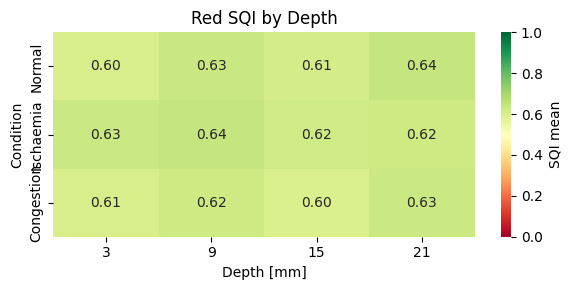

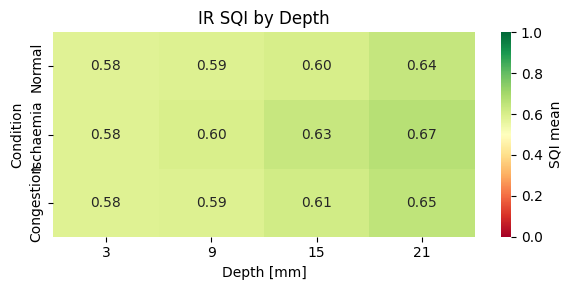

In [23]:
#SQIヒートマップの描画

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== SQI 集計結果の読み込み =====
df_sqi = pd.read_csv("SQI_summary1.csv")

# ===== Red と IR に分ける =====
df_red = df_sqi[df_sqi["Channel"] == "Red"]
df_ir  = df_sqi[df_sqi["Channel"] == "IR"]

# ===== Pivotしてヒートマップ用の表を作成 =====
red_pivot = df_red.pivot(index="Condition", columns="Depth", values="SQI_mean")
ir_pivot  = df_ir.pivot(index="Condition", columns="Depth", values="SQI_mean")

# Condition の表示順を統一
order = ["Normal", "Ischaemia", "Congestion"]
red_pivot = red_pivot.reindex(order)
ir_pivot  = ir_pivot.reindex(order)

# ===== ヒートマップ描画 =====
def plot_sqi_heatmap(data, title):
    plt.figure(figsize=(6,3))
    sns.heatmap(
        data,
        annot=True, fmt=".2f",
        cmap="RdYlGn", center=0.5,  # 0.5 を基準色に
        vmin=0, vmax=1,             # SQI の範囲を 0〜1 に固定
        cbar_kws={"label": "SQI mean"}
    )
    plt.title(title)
    plt.xlabel("Depth [mm]")
    plt.ylabel("Condition")
    plt.tight_layout()
    plt.show()

plot_sqi_heatmap(red_pivot, "Red SQI by Depth")
plot_sqi_heatmap(ir_pivot,  "IR SQI by Depth")

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from scipy.signal import detrend, butter, filtfilt, find_peaks

fs = 2000
depths = [3, 9, 15, 21]
group_names = ["Normal", "Ischaemia", "Congestion"]

def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, sig)

def estimate_bpm(signal, fs=2000):
    sig = pd.Series(signal, dtype=float).interpolate().fillna(0).values
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    prom = max(np.std(sig)*0.3, np.ptp(sig)*0.05)
    peaks,_ = find_peaks(sig, prominence=prom, distance=int(fs*0.5))
    if len(peaks) < 2:
        return np.nan
    return len(peaks)/(len(sig)/fs/60)

results = []

for depth in depths:
    files = [
        (f"{depth}mm_AGC1_data1.csv", "Normal"),
        (f"{depth}mm_AGC1_data2.csv", "Ischaemia"),
        (f"{depth}mm_AGC1_data3.csv", "Congestion"),
    ]

    red_groups, ir_groups = [], []

    for file,_ in files:
        df = pd.read_csv(file)
        if not {"ppgA_Red_AGC","ppgA_IR_AGC","ppgA_IR_raw"}.issubset(df.columns):
            red_groups.append([]); ir_groups.append([]); continue

        red = df["ppgA_Red_AGC"].astype(float).dropna().values
        ir  = df["ppgA_IR_AGC"].astype(float).dropna().values
        if len(red)<5 or len(ir)<5:
            red_groups.append([]); ir_groups.append([]); continue

        # bpmはrawで計算（安定のため）
        bpm = estimate_bpm(df["ppgA_IR_raw"].values, fs)
        if np.isnan(bpm) or bpm<=0:
            window_sec = 1
        else:
            window_sec = max(3.0, 60.0/bpm*3.0)

        step = int(window_sec*fs)
        if step >= len(red):  
            step = max(10, len(red)//2)
        hop = max(1, step//2)

        red_amp, ir_amp = [], []
        for start in range(0, len(red)-step+1, hop):
            rseg = red[start:start+step]; iseg = ir[start:start+step]
            if len(rseg)>1 and len(iseg)>1:
                red_amp.append(np.ptp(rseg))
                ir_amp.append(np.ptp(iseg))
        if not red_amp:  # 最低1窓保証
            red_amp.append(np.ptp(red))
            ir_amp.append(np.ptp(ir))

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ===== チャンネルごとにスケーリング =====
    # Red → その深さのNormal Red平均
    normal_red_mean = np.mean(red_groups[0]) if len(red_groups[0])>0 else np.nan
    if not np.isfinite(normal_red_mean) or normal_red_mean<=0:
        red_scale = 1.0
    else:
        red_scale = 0.5 / normal_red_mean
    red_scaled = [[v*red_scale for v in g] for g in red_groups]

    # IR → その深さのNormal IR平均
    normal_ir_mean = np.mean(ir_groups[0]) if len(ir_groups[0])>0 else np.nan
    if not np.isfinite(normal_ir_mean) or normal_ir_mean<=0:
        ir_scale = 1.0
    else:
        ir_scale = 0.5 / normal_ir_mean
    ir_scaled  = [[v*ir_scale for v in g] for g in ir_groups]

    # ===== Kruskal-Wallis =====
    stat_red, p_red = (kruskal(*[g for g in red_scaled if len(g)>0]) 
                       if sum(len(g)>0 for g in red_scaled)>=2 else (np.nan,np.nan))
    stat_ir, p_ir   = (kruskal(*[g for g in ir_scaled if len(g)>0]) 
                       if sum(len(g)>0 for g in ir_scaled)>=2 else (np.nan,np.nan))

    results.append({"Depth":f"{depth}mm","Channel":"Red","Chi-Squared":stat_red,"df":len(red_scaled)-1,"p-Value":p_red})
    results.append({"Depth":f"{depth}mm","Channel":"IR","Chi-Squared":stat_ir,"df":len(ir_scaled)-1,"p-Value":p_ir})

df_result = pd.DataFrame(results)
df_result.to_csv("KW_result1.csv",index=False)
print("✅ Kruskal-Wallis 検定結果を保存 → KW_result1.csv")
print(df_result.round(4))

# 15 mm Red はそもそも Normal と Congestion がほぼ同じ → 全体としての差が弱い。


✅ Kruskal-Wallis 検定結果を保存 → KW_result1.csv
  Depth Channel  Chi-Squared  df  p-Value
0   3mm     Red      37.3966   2   0.0000
1   3mm      IR      49.2555   2   0.0000
2   9mm     Red      23.9375   2   0.0000
3   9mm      IR      47.4217   2   0.0000
4  15mm     Red       1.9152   2   0.3838
5  15mm      IR      42.9949   2   0.0000
6  21mm     Red      16.4581   2   0.0003
7  21mm      IR      40.4159   2   0.0000


In [39]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, norm
import os

# ===== パラメータ =====
fs = 2000
window_sec = 1
depths = [3, 9, 15, 21]
states = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
group_names = list(states.values())

# ===== Dunn test関数 =====
def dunn_test(groups, group_labels):
    """Dunnの多重比較検定（Bonferroni補正）"""
    groups = [np.array(g, dtype=float) for g in groups if len(g) > 0]
    valid_labels = [group_labels[i] for i, g in enumerate(groups) if len(g) > 0]

    if len(groups) < 2:
        return pd.DataFrame(columns=["Comparison", "Z", "p (Unadjusted)", "p (Adjusted)"])

    data = np.concatenate(groups)
    groups_id = np.concatenate([[i]*len(g) for i, g in enumerate(groups)])
    ranks = rankdata(data)
    n = len(data)

    # ties correction
    ties = pd.Series(ranks).value_counts()
    ties_correction = 1 - (np.sum(ties**3 - ties) / (n**3 - n))
    ties_correction = max(ties_correction, 1e-8)

    n_i = [len(g) for g in groups]
    R_i = [np.sum(ranks[groups_id == i]) for i in range(len(groups))]
    mean_rank_i = [R_i[i] / n_i[i] for i in range(len(groups))]

    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            diff = mean_rank_i[i] - mean_rank_i[j]
            SE = np.sqrt((n*(n+1)/12) * (1/n_i[i] + 1/n_i[j]) * ties_correction)
            if SE == 0:
                continue
            Z = diff / SE
            p = 2 * (1 - norm.cdf(abs(Z)))  # 両側
            results.append({
                "Comparison": f"{valid_labels[i]} vs {valid_labels[j]}",
                "Z": Z,
                "p (Unadjusted)": p
            })

    df = pd.DataFrame(results)
    if not df.empty:
        # Bonferroni補正
        df["p (Adjusted)"] = np.minimum(df["p (Unadjusted)"] * len(df), 1.0)
    return df

# ===== 結果格納用 =====
all_results = []

for depth in depths:
    red_groups = []
    ir_groups = []

    for data_key in states:
        file = f"{depth}mm_AGC1_{data_key}.csv"  # ★ AGC1を明示
        if not os.path.exists(file):
            print(f"⚠️ File not found: {file}")
            red_groups.append([])
            ir_groups.append([])
            continue

        df = pd.read_csv(file)

        # データ安全化
        red = df.get("ppgA_Red_AGC", pd.Series(dtype=float)).values
        ir  = df.get("ppgA_IR_AGC", pd.Series(dtype=float)).values
        red = red[np.isfinite(red)]
        ir  = ir[np.isfinite(ir)]

        step = int(fs * window_sec)
        red_amp = [
            np.ptp(red[i:i+step]) for i in range(0, len(red) - step + 1, step)
            if len(red[i:i+step]) > 1
        ]
        ir_amp = [
            np.ptp(ir[i:i+step]) for i in range(0, len(ir) - step + 1, step)
            if len(ir[i:i+step]) > 1
        ]

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ========== Dunn検定 (Red) ==========
    df_dunn_red = dunn_test(red_groups, group_names)
    if not df_dunn_red.empty:
        df_dunn_red.insert(1, "Channel", "Red")
        df_dunn_red.insert(2, "Depth", f"{depth}mm")
        all_results.append(df_dunn_red)

    # ========== Dunn検定 (IR) ==========
    df_dunn_ir = dunn_test(ir_groups, group_names)
    if not df_dunn_ir.empty:
        df_dunn_ir.insert(1, "Channel", "IR")
        df_dunn_ir.insert(2, "Depth", f"{depth}mm")
        all_results.append(df_dunn_ir)

# ===== 結果統合・保存 =====
if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    df_all = df_all[["Comparison", "Channel", "Depth", "Z", "p (Unadjusted)", "p (Adjusted)"]]

    # 表示
    print("\n=== Dunn post-hoc test results across all depths ===")
    print(df_all.round(4))

    # 保存
    df_all.to_csv("dunn_posthoc_all_depths1.csv", index=False)
    print("\n✅ Dunn test results saved to 'dunn_posthoc_all_depths1.csv'")
else:
    print("⚠️ No valid groups for Dunn test.")





=== Dunn post-hoc test results across all depths ===
                 Comparison Channel Depth       Z  p (Unadjusted)  \
0       Normal vs Ischaemia     Red   3mm  6.7898          0.0000   
1      Normal vs Congestion     Red   3mm  0.2372          0.8125   
2   Ischaemia vs Congestion     Red   3mm -6.5526          0.0000   
3       Normal vs Ischaemia      IR   3mm  8.2526          0.0000   
4      Normal vs Congestion      IR   3mm  5.0899          0.0000   
5   Ischaemia vs Congestion      IR   3mm -3.1627          0.0016   
6       Normal vs Ischaemia     Red   9mm  2.8982          0.0038   
7      Normal vs Congestion     Red   9mm -1.9995          0.0456   
8   Ischaemia vs Congestion     Red   9mm -4.8730          0.0000   
9       Normal vs Ischaemia      IR   9mm  7.7416          0.0000   
10     Normal vs Congestion      IR   9mm  2.2175          0.0266   
11  Ischaemia vs Congestion      IR   9mm -5.5715          0.0000   
12      Normal vs Ischaemia     Red  15mm  1.3293

/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_57407/550681728.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_57407/550681728.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_57407/550681728.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_57407/550681728.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolo

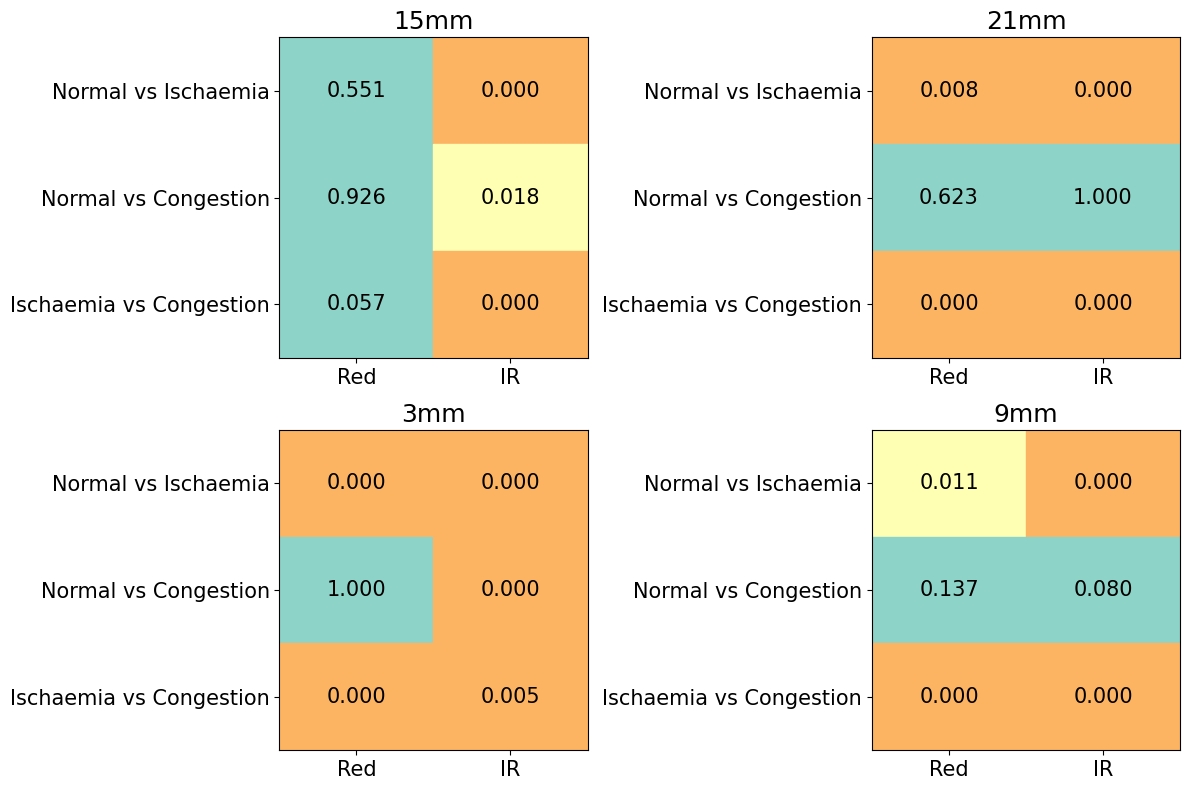

In [40]:
# 再度必要なパッケージをインポートしてコードを実行

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ファイル読み込み
df = pd.read_csv("dunn_posthoc_all_depths1.csv")

# 深さごとのデータに分割
depths = df["Depth"].unique()
depths.sort()

# 比較軸とチャネルの順序を定義
comparisons = ["Normal vs Ischaemia", "Normal vs Congestion", "Ischaemia vs Congestion"]
channels = ["Red", "IR"]

# 色のマップ関数：p値に応じて色を設定
def get_color(p):
    if p < 0.01:
        return "#fdb462"  # 優しい青緑
    elif p < 0.05:
        return "#ffffb3"  # 優しい黄色
    else:
        return "#8dd3c7"  # 優しいオレンジ

# プロット準備
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, depth in enumerate(depths):
    ax = axes[idx]
    sub_df = df[df["Depth"] == depth]

    # 描画用マトリクス作成
    heatmap_data = pd.DataFrame(index=comparisons, columns=channels)

    for _, row in sub_df.iterrows():
        heatmap_data.loc[row["Comparison"], row["Channel"]] = row["p (Adjusted)"]

    # 数値のp値を float で保存し、色塗り用に用いる
    p_values = heatmap_data.astype(float)

    # 手動で heatmap 描画（p値に応じた背景色、文字重ね）
    for i, comp in enumerate(comparisons):
        for j, ch in enumerate(channels):
            p_val = p_values.loc[comp, ch]
            color = get_color(p_val)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
            ax.text(j + 0.5, i + 0.5, f"{p_val:.3f}", ha='center', va='center', fontsize=15)

    # 軸設定
    ax.set_xticks(np.arange(len(channels)) + 0.5)
    ax.set_yticks(np.arange(len(comparisons)) + 0.5)
    ax.set_xticklabels(channels, fontsize=15)
    ax.set_yticklabels(comparisons, fontsize=15)
    ax.set_xlim(0, len(channels))
    ax.set_ylim(0, len(comparisons))
    ax.set_title(f"{depth}", fontsize=18)
    ax.invert_yaxis()
    ax.set_aspect('auto')  # 自動で長方形化
    ax.grid(False)

plt.tight_layout()
plt.show()


In [50]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks, detrend, butter, filtfilt
from sklearn.metrics import roc_auc_score, roc_curve

# ========= 基本設定 =========
fs = 2000  # Hz
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}
channels = {"ppgA_Red_AGC": "Red", "ppgA_IR_AGC": "IR"} 

# --- バンドパスフィルタ (bpm 推定用) ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, sig)

# --- bpm 推定 ---
def estimate_bpm(signal, fs=2000):
    sig = pd.Series(signal, dtype=float).interpolate().fillna(0).values
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    prom = max(np.std(sig) * 0.3, np.ptp(sig) * 0.05)
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs * 0.5))
    if len(peaks) < 2:
        return np.nan
    duration_sec = len(sig) / fs
    bpm = len(peaks) / (duration_sec / 60.0)
    return bpm

# --- 1拍ごとの特徴抽出 ---
def extract_pulse_features(signal, fs, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs * dist))
    feats = []
    if len(peaks) < 2:
        return []
    for p in peaks:
        left = max(0, p - int(0.5 * fs))
        right = min(len(signal), p + int(0.5 * fs))
        seg = signal[left:right]
        if len(seg) < 5:
            continue
        peak_idx = np.argmax(seg)
        trough_idx = np.argmin(seg[:peak_idx+1])
        next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])
        if trough_idx < peak_idx < next_trough_idx:
            rise = (peak_idx - trough_idx) / fs
            fall = (next_trough_idx - peak_idx) / fs
            baseline = seg[trough_idx]
            peak_val = seg[peak_idx]
            half = baseline + 0.5 * (peak_val - baseline)
            seg_pw = seg[trough_idx:next_trough_idx+1]
            above = np.where(seg_pw >= half)[0]
            pw = (above[-1] - above[0]) / fs if len(above) > 1 else np.nan
            amp = peak_val - baseline
            feats.append((rise, fall, pw, amp))
    return feats

# ========= データ読み込み & 特徴抽出 =========
records = []
pulse_id_counter = 0

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC1_data{i_state}.csv")
        if not file.exists():
            print(f"⚠️ File not found: {file}")
            continue
            
        df = pd.read_csv(file)

        # --- bpm を IR 信号から推定 ---
        if "ppgA_IR_AGC" not in df.columns:
            print(f"⚠️ {file.name} に IR 列がありません")
            continue
        bpm = estimate_bpm(df["ppgA_IR_AGC"].values, fs)
        if np.isnan(bpm) or bpm <= 0:
            window_sec = 1.0
            print(f"[警告] {file.name}: bpm推定失敗 → デフォルト1s窓")
        else:
            window_sec = 60.0 / bpm
            window_sec = float(np.clip(window_sec, 0.6, 2.0))
            print(f"{file.name}: 推定bpm={bpm:.1f}, window_sec={window_sec:.2f}s")

        step = int(round(fs * window_sec))

        for col, ch_label in channels.items():
            if col not in df.columns:
                continue
            sig = df[col].values

            # (1) 1拍ごとのAmplitude
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                if len(seg) < 5:
                    continue
                amp = seg.max() - seg.min()
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter,
                    "RiseTime": np.nan, "FallTime": np.nan,
                    "PulseWidth": np.nan, "Amplitude": amp
                })

            # (2) peaksで詳細特徴抽出
            feats = extract_pulse_features(sig, fs)
            for r, f, pw, amp in feats:
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter,
                    "RiseTime": r, "FallTime": f,
                    "PulseWidth": pw, "Amplitude": amp
                })
            pulse_id_counter += 1

df_feat = pd.DataFrame(records)
if df_feat.empty:
    raise RuntimeError("Error: No data loaded. Please check CSV files.")

# ========= 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime"] / (df_feat["FallTime"] + 1e-6)
df_feat["Pulse_Area"] = df_feat["PulseWidth"] * df_feat["Amplitude"]

# ========= 正規化（Redは3mm Red Normal基準、IRは3mm IR Normal基準） =========
def normalize_channel(df, ch):
    base = df.query("Channel==@ch and Depth==3 and State=='Normal'")["Amplitude"].mean()
    if pd.isna(base) or base == 0:
        print(f"⚠️ Baseline amplitude for 3mm Normal {ch} missing")
        df.loc[df.Channel == ch, "Amp_norm"] = np.nan
    else:
        df.loc[df.Channel == ch, "Amp_norm"] = df.loc[df.Channel == ch, "Amplitude"] / base

normalize_channel(df_feat, "Red")
normalize_channel(df_feat, "IR")

df_feat["Pulse_Area_norm"] = df_feat["PulseWidth"] * df_feat["Amp_norm"]

# ========= Red/IR比 =========
amp_data = df_feat.dropna(subset=['Amplitude', 'Amp_norm']).copy()

df_red = amp_data[amp_data.Channel == "Red"].rename(
    columns={"Amplitude": "Amplitude_Red", "Amp_norm": "Amp_norm_Red"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_Red', 'Amp_norm_Red']]

df_ir = amp_data[amp_data.Channel == "IR"].rename(
    columns={"Amplitude": "Amplitude_IR", "Amp_norm": "Amp_norm_IR"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_IR', 'Amp_norm_IR']]

df_ratio = pd.merge(df_red, df_ir, on=['Depth','State','Pulse_ID'], how='inner')
df_ratio["Red_IR_amp_ratio"] = df_ratio["Amplitude_Red"] / (df_ratio["Amplitude_IR"] + 1e-6)
df_ratio["Red_IR_amp_norm_ratio"] = df_ratio["Amp_norm_Red"] / (df_ratio["Amp_norm_IR"] + 1e-6)

# ========= ROC AUC =========
pairs = [("Normal","Ischaemia"),("Normal","Congestion"),("Ischaemia","Congestion")]
features_to_eval = ["Amp_norm","RiseTime","FallTime","PulseWidth","RiseFall_ratio","Pulse_Area"]
ratio_features_to_eval = ["Red_IR_amp_ratio","Red_IR_amp_norm_ratio"]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=200):
    rng = np.random.default_rng(42)
    aucs=[]
    n=len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0,n,n)
        if len(np.unique(y_true[idx]))<2 or np.all(y_score[idx]==y_score[idx][0]):
            continue
        aucs.append(roc_auc_score(y_true[idx],y_score[idx]))
    if not aucs: return np.nan,np.nan,np.nan
    return np.mean(aucs), np.percentile(aucs,2.5), np.percentile(aucs,97.5)

rows=[]
for ch in ["Red","IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel==ch)&(df_feat.Depth==depth)]
        if sub.empty: continue
        for f in features_to_eval:
            for c1,c2 in pairs:
                d=sub[sub.State.isin([c1,c2])]
                if d.empty: continue
                y_true=(d.State==c1).astype(int).values
                y_score=d[f].values
                mask=~np.isnan(y_score)
                y_true=y_true[mask]; y_score=y_score[mask]
                if len(y_true)<10 or len(np.unique(y_true))<2: continue
                auc=roc_auc_score(y_true,y_score)
                auc_bs,ci_lo,ci_hi=bootstrap_auc_ci(y_true,y_score)
                fpr,tpr,thr=roc_curve(y_true,y_score)
                youden=tpr-fpr; idx=np.argmax(youden)
                rows.append({"Channel":ch,"Depth":depth,"Feature":f,"Pair":f"{c1} vs {c2}",
                             "AUC":auc,"AUC_bootstrap_mean":auc_bs,"CI_lower":ci_lo,"CI_upper":ci_hi,
                             "Cutoff":thr[idx],"Sensitivity":tpr[idx],"Specificity":1-fpr[idx],"n_samples":len(y_true)})

for depth in depths:
    sub=df_ratio[df_ratio.Depth==depth]
    if sub.empty: continue
    for f in ratio_features_to_eval:
        for c1,c2 in pairs:
            d=sub[sub.State.isin([c1,c2])]
            if d.empty: continue
            y_true=(d.State==c1).astype(int).values
            y_score=d[f].values
            mask=~np.isnan(y_score)
            y_true=y_true[mask]; y_score=y_score[mask]
            if len(y_true)<10 or len(np.unique(y_true))<2: continue
            auc=roc_auc_score(y_true,y_score)
            auc_bs,ci_lo,ci_hi=bootstrap_auc_ci(y_true,y_score)
            fpr,tpr,thr=roc_curve(y_true,y_score)
            youden=tpr-fpr; idx=np.argmax(youden)
            rows.append({"Channel":"Red/IR_Ratio","Depth":depth,"Feature":f,"Pair":f"{c1} vs {c2}",
                         "AUC":auc,"AUC_bootstrap_mean":auc_bs,"CI_lower":ci_lo,"CI_upper":ci_hi,
                         "Cutoff":thr[idx],"Sensitivity":tpr[idx],"Specificity":1-fpr[idx],"n_samples":len(y_true)})

df_auc_feat = pd.DataFrame(rows)
df_auc_feat.to_csv("AUC_all_features_95CI_final_RedIRRatio1.csv", index=False)
print("✅ Saved AUC_all_features_95CI_final_RedIRRatio1.csv")



3mm_AGC1_data1.csv: 推定bpm=60.8, window_sec=0.99s
3mm_AGC1_data2.csv: 推定bpm=62.7, window_sec=0.96s
3mm_AGC1_data3.csv: 推定bpm=62.3, window_sec=0.96s
9mm_AGC1_data1.csv: 推定bpm=60.4, window_sec=0.99s
9mm_AGC1_data2.csv: 推定bpm=64.7, window_sec=0.93s
9mm_AGC1_data3.csv: 推定bpm=64.3, window_sec=0.93s
15mm_AGC1_data1.csv: 推定bpm=60.4, window_sec=0.99s
15mm_AGC1_data2.csv: 推定bpm=60.8, window_sec=0.99s
15mm_AGC1_data3.csv: 推定bpm=60.8, window_sec=0.99s
21mm_AGC1_data1.csv: 推定bpm=65.1, window_sec=0.92s
21mm_AGC1_data2.csv: 推定bpm=63.2, window_sec=0.95s
21mm_AGC1_data3.csv: 推定bpm=63.2, window_sec=0.95s
✅ Saved AUC_all_features_95CI_final_RedIRRatio1.csv


/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_57407/1465238841.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


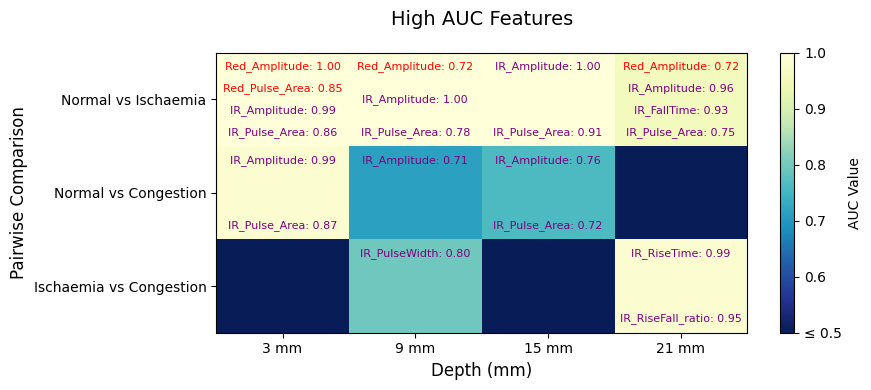

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ========= 1. データ読み込みと準備 =========
FILE_PATH = "AUC_all_features_95CI_final_RedIRRatio1.csv"  # 最終AUC集計ファイル
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: File not found at {FILE_PATH}. CSVを生成してください。")

# NaN除去 & AUC>0.7 のみプロット対象に
df_filtered = df.dropna(subset=['AUC_bootstrap_mean'])
df_filtered_plot = df_filtered[df_filtered['AUC_bootstrap_mean'] > 0.7].copy()

# ========= 2. 特徴量の整形と色の定義 =========

def format_feature_name(row):
    """特徴名を統一的にフォーマット"""
    feature = row['Feature']
    channel = row['Channel']

    if feature == 'Amp_norm':  # Amplitudeに統一
        feature = 'Amplitude'
    if feature == 'Pulse_Area_norm':
        return None

    # ChannelとFeatureの結合
    if channel in ['Red', 'IR']:
        return f"{channel}_{feature}"
    elif channel == 'Red/IR_Ratio':
        return feature
    return None

df_filtered_plot['Combined_Feature'] = df_filtered_plot.apply(format_feature_name, axis=1)
df_filtered_plot = df_filtered_plot.dropna(subset=['Combined_Feature'])

def get_feature_color(feature_name):
    """Red/IRに基づいて色を決定"""
    feature_name = feature_name.lower()
    if 'red' in feature_name:
        return 'red'
    elif 'ir' in feature_name:
        return 'purple'
    return 'black'

pair_order = [
    'Normal vs Ischaemia',
    'Normal vs Congestion',
    'Ischaemia vs Congestion'
]
depth_order = sorted(df_filtered_plot['Depth'].unique())

# ========= 3. ヒートマップデータ構築 =========
text_grid = {}
heatmap_values = pd.DataFrame(index=pair_order, columns=depth_order, dtype=float)

for _, row in df_filtered_plot.iterrows():
    pair = row['Pair']
    depth = row['Depth']
    feature_name = row['Combined_Feature']
    auc_value = row['AUC_bootstrap_mean']

    key = (pair, depth)
    text = f"{feature_name}: {auc_value:.2f}"
    color = get_feature_color(feature_name)

    if key not in text_grid:
        text_grid[key] = []
    text_grid[key].append((text, color, auc_value))

    # セルの最大AUCを背景色用に記録
    if pair in pair_order and depth in depth_order:
        current = heatmap_values.loc[pair, depth]
        if pd.isna(current) or auc_value > current:
            heatmap_values.loc[pair, depth] = auc_value

# AUCがないセルは最低値(0.5)で埋める
MIN_AUC_FOR_CMAP = 0.5
heatmap_values = heatmap_values.fillna(MIN_AUC_FOR_CMAP)

# ========= 4. ヒートマップの描画 =========
fig, ax = plt.subplots(figsize=(9, 4))

cmap = plt.cm.get_cmap('YlGnBu_r')
norm = mcolors.Normalize(vmin=MIN_AUC_FOR_CMAP, vmax=1.0)

cax = ax.imshow(heatmap_values.values, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')

# 軸設定
ax.set_xticks(np.arange(len(depth_order)))
ax.set_yticks(np.arange(len(pair_order)))
ax.set_xticklabels([f'{d} mm' for d in depth_order], fontsize=10)
ax.set_yticklabels(pair_order, fontsize=10)
ax.set_xlabel('Depth (mm)', fontsize=12)
ax.set_ylabel('Pairwise Comparison', fontsize=12)
ax.set_title('High AUC Features', fontsize=14, pad=20)

# テキスト描画
for i, pair in enumerate(pair_order):
    for j, depth in enumerate(depth_order):
        key = (pair, depth)
        if key in text_grid and heatmap_values.loc[pair, depth] > 0.7:
            entries = [(t, c) for t, c, _ in text_grid[key]]
            n_entries = len(entries)
            y_offsets = np.linspace(-0.35, 0.35, n_entries)
            for k, (text, color) in enumerate(entries):
                ax.text(j, i + y_offsets[k],
                        text,
                        ha="center",
                        va="center",
                        color=color,
                        fontsize=8,
                        linespacing=1.2)

# カラーバー
cbar_ticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar = fig.colorbar(cax, ticks=cbar_ticks, label='AUC Value')
custom_labels = [f'{t:.1f}' for t in cbar_ticks]
custom_labels[0] = f'≤ {MIN_AUC_FOR_CMAP:.1f}'
cbar.ax.set_yticklabels(custom_labels)

plt.tight_layout()
plt.show()
